# Setup

## Imports

In [1]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

In [2]:
from vai.plot import smooth_plot

PyTorch Modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

## HyperParameters

In [5]:
gpu = True
batch_size = 64
val_split = 0.2

In [6]:
if gpu and not torch.cuda.is_available():
    raise RuntimeError('GPU is either unavalable or not configured properly.\n'
                      'Turn off the --gpu flag and try again.')

## Define Useful Features

In [7]:
jtplot.style(figsize=(15, 10), fscale=2, context='notebook')

In [8]:
DIR_DATA = Path('~/.data/MNIST').expanduser()
DIR_DATA.mkdir(parents=True, exist_ok=True)

In [9]:
cuda = lambda x: x.cuda() if torch.cuda.is_available() and gpu else x

In [10]:
_flatten = lambda x: x.view(x.size(0), -1)

In [11]:
def test_model():
    model.eval()
    images = cuda(torch.zeros(5, 10, 28, 28))
    
    images_gethered = [0] * 10
    for x, _ in data_val:
        x = Variable(cuda(x), volatile=True).squeeze(1)
        y = model(_flatten(x)).max(1)[1].data
        x = x.data
        
        for i in range(10):
            if images_gethered[i] >= 5: continue
                
            y_i = cuda(torch.arange(len(y)))[y == i].long()
            if len(y_i) == 0: continue
            
            x_i = x.index_select(0, y_i)
            x_i = x_i[:min(len(x_i), 5 - images_gethered[i])]
            images[images_gethered[i]:images_gethered[i] + len(x_i), i] = x_i

            images_gethered[i] += len(x_i)

        if all(i >= 5 for i in images_gethered): break
        

    show_images(images.view(-1, 28, 28).cpu().numpy(),
                cmap='gray', pixel_range=(-1, 1))
    
    model.train()

## Load Data

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5] * 3, [0.5] * 3)])

In [13]:
_dataset = MNIST(DIR_DATA, transform=transform, download=True)
_len_train = int((1 - val_split) * len(_dataset))

In [14]:
data = DataLoader(_dataset, batch_size, num_workers=8,
                  sampler=SubsetRandomSampler(list(range(_len_train))))
data_val = DataLoader(_dataset, batch_size,
                      shuffle=False, num_workers=8, drop_last=True,
                      sampler=SubsetRandomSampler(list(range(_len_train, len(_dataset)))))

An infinite generator

In [15]:
def data_generator():
    while True:
        data_iterator = iter(data)
        for x, y in data_iterator:
            yield Variable(cuda(_flatten(x))), Variable(cuda(y))

# Create Model

In [16]:
model = cuda(nn.Linear(784, 10))
history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
optimizer = optim.Adam(model.parameters())

In [17]:
criterion = nn.CrossEntropyLoss()

# Train Model

In [18]:
_get_metrics = lambda y_pred, y: (criterion(y_pred, y),
                                  (y_pred.max(1)[1] == y).float().mean().data.cpu().numpy()[0])

In [19]:
def _append_val():
    model.eval()
    
    total_loss = 0; total_acc = 0
    
    x, y = next(iter(data_val))
    x = Variable(cuda(x), volatile=True); y = Variable(cuda(y), volatile=True)
    y_pred = model(_flatten(x))

    loss, acc = _get_metrics(y_pred, y)
        
    history['val_loss'].append(loss.data.cpu().numpy()[0])
    history['val_acc'].append(acc)
    
    model.train()

In [20]:
def optimize(epochs=1, iterations=-1):
    if iterations <= 0: iterations = int(len(data) * epochs)
    gen = data_generator()
    
    for batch in tqdm(range(iterations)):
        x, y = next(gen)
        y_pred = model(x)
        
        loss, acc = _get_metrics(y_pred, y)
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        history['loss'].append(loss.data.cpu().numpy()[0])
        history['acc'].append(acc)
        if batch % 50 == 0: _append_val()

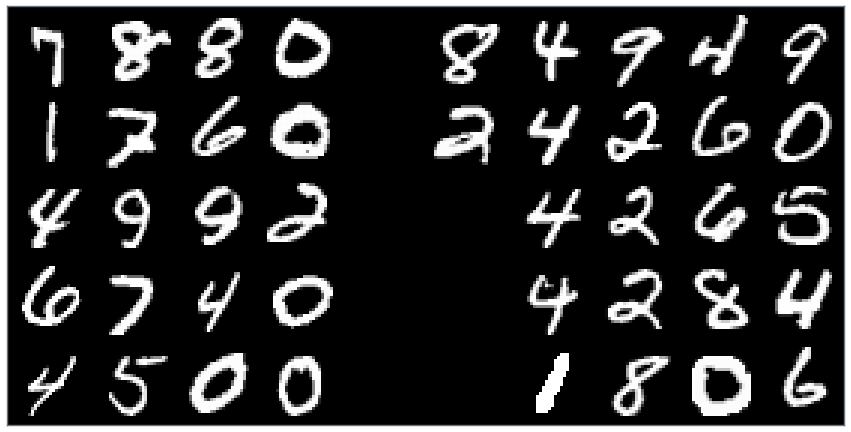

In [21]:
test_model()

In [22]:
optimize(iterations=101)

HBox(children=(IntProgress(value=0, max=101), HTML(value='')))

# Show Results

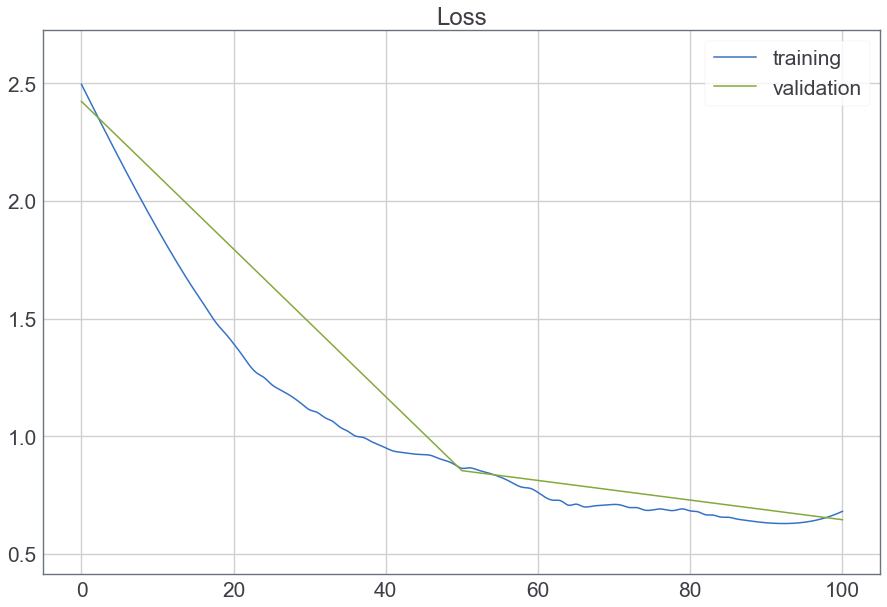

In [23]:
smooth_plot(history['loss'], label='training', replace_outliers=False)
plot(np.arange(len(history['val_loss'])) * 50,
            history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

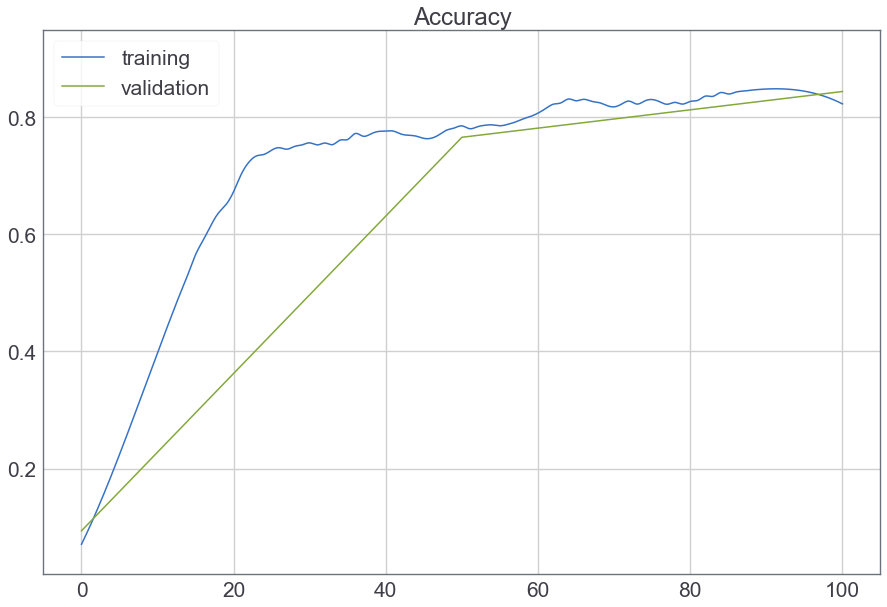

In [24]:
smooth_plot(history['acc'], label='training', replace_outliers=False)
plot(np.arange(len(history['val_acc'])) * 50,
            history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

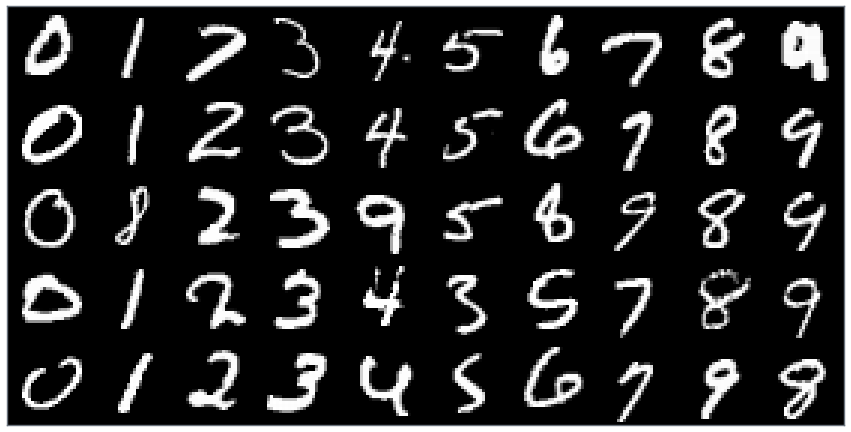

In [25]:
test_model()